In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta

In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [12]:
nlp = spacy.load("en_core_web_sm")

In [28]:
def generate_mock_dataset(num_samples=200):
    """Generate realistic logistics support tickets"""
    
    # Base templates
    templates = {
        "Delivery Delay": [
            "My package is delayed by {days} days",
            "Order #{order_id} hasn't arrived yet",
            "Shipment was supposed to arrive on {date} but still not here",
            "Why is my package taking so long? Expected delivery was {date}",
            "Tracking shows delay for order #{order_id}"
        ],
        "Product Issue": [
            "Received wrong item for order #{order_id}",
            "Product arrived damaged",
            "Missing items from my order #{order_id}",
            "Received defective product",
            "Wrong color/size received"
        ],
        "Tracking": [
            "Tracking number {tracking_id} not working",
            "Where is my order #{order_id}?",
            "No updates on my shipment",
            "Tracking shows delivered but I didn't receive it",
            "How to track international shipment?"
        ],
        "Billing": [
            "Charged twice for order #{order_id}",
            "Invoice amount doesn't match what I paid",
            "Need refund for canceled order #{order_id}",
            "Payment processed but order not confirmed",
            "Unexpected charges on my card"
        ],
        "Service Quality": [
            "Delivery agent was rude",
            "Poor packaging for order #{order_id}",
            "Driver didn't follow delivery instructions",
            "Customer service representative was unhelpful",
            "Complaint about delivery service in {city}"
        ],
        "Lost Package": [
            "Package marked delivered but not received",
            "Order #{order_id} lost in transit",
            "Tracking shows delivered but nothing arrived",
            "Missing package for 2 weeks",
            "Carrier says delivered but I don't have it"
        ]
    }
    
    # Generate realistic data
    data = []
    categories = list(templates.keys())
    
    for _ in range(num_samples):
        category = random.choice(categories)
        template = random.choice(templates[category])
        
        # Fill template variables
        filled_text = template.format(
            days=random.randint(1, 10),
            order_id=''.join(random.choices('ABCDEFGHJKLMNPQRSTUVWXYZ23456789', k=8)),
            tracking_id=''.join(random.choices('0123456789', k=12)),
            date=(datetime.now() - timedelta(days=random.randint(1, 14))).strftime('%Y-%m-%d'),
            city=random.choice(['Mumbai', 'Delhi', 'Bangalore', 'Hyderabad', 'Chennai'])
        )
        
        data.append({
            "ticket_id": f"TKT-{''.join(random.choices('0123456789', k=6))}",
            "ticket_text": filled_text,
            "category": category,
            "urgency": random.choice(["Low", "Medium", "High"]),
            "customer_id": f"CUST-{''.join(random.choices('0123456789', k=5))}"
        })
    
    return pd.DataFrame(data)

# Generate and save dataset
df = generate_mock_dataset(250)
print(f"Generated dataset with {len(df)} tickets")
print(df.head())

Generated dataset with 250 tickets
    ticket_id                                       ticket_text  \
0  TKT-227133         Package marked delivered but not received   
1  TKT-524296                 Charged twice for order #KW6MGCX2   
2  TKT-116535  Tracking shows delivered but I didn't receive it   
3  TKT-413982        Carrier says delivered but I don't have it   
4  TKT-700035                Poor packaging for order #X8FSV872   

          category urgency customer_id  
0     Lost Package  Medium  CUST-68759  
1          Billing     Low  CUST-68720  
2         Tracking  Medium  CUST-59807  
3     Lost Package     Low  CUST-89040  
4  Service Quality  Medium  CUST-62195  


Generated dataset with 250 tickets
    ticket_id                           ticket_text       category urgency  \
0  TKT-814713         Unexpected charges on my card        Billing     Low   
1  TKT-903888         Unexpected charges on my card        Billing  Medium   
2  TKT-762437               Product arrived damaged  Product Issue    High   
3  TKT-884368             Wrong color/size received  Product Issue     Low   
4  TKT-533316  How to track international shipment?       Tracking  Medium   

  customer_id  
0  CUST-13346  
1  CUST-48594  
2  CUST-01066  
3  CUST-03421  
4  CUST-47181  

=== Dataset Overview ===
Total tickets: 250

Category Distribution:
category
Service Quality    19.6
Delivery Delay     17.2
Lost Package       17.2
Billing            15.6
Tracking           15.6
Product Issue      14.8
Name: proportion, dtype: float64


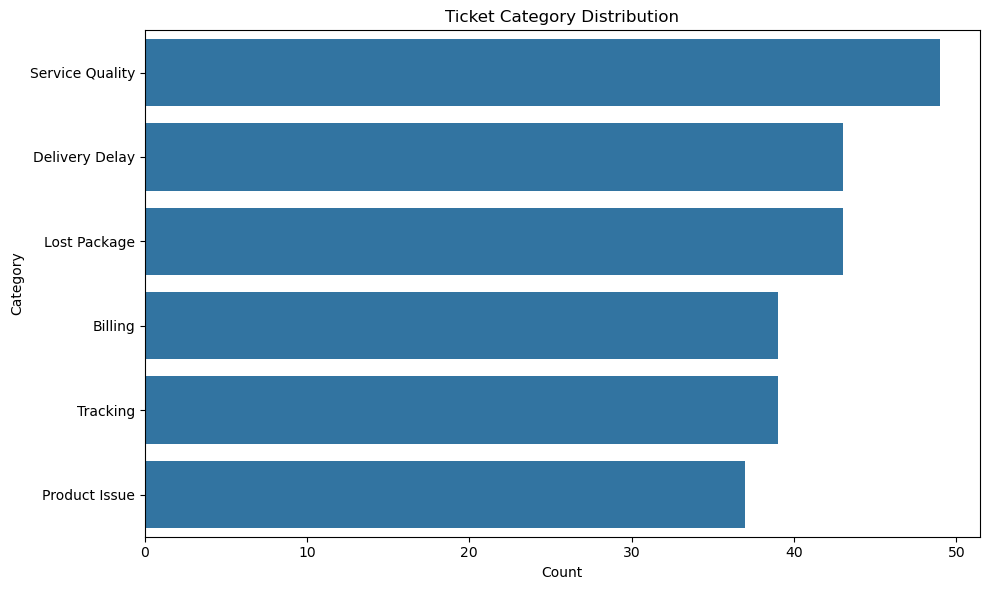


Urgency Distribution:
urgency
High      87
Low       82
Medium    81
Name: count, dtype: int64


In [30]:
# Generate and save dataset
df = generate_mock_dataset(250)
df.to_csv("logistics_tickets_large.csv", index=False)
print(f"Generated dataset with {len(df)} tickets")
print(df.head())

# ========================
# 2. Data Exploration
# ========================

print("\n=== Dataset Overview ===")
print(f"Total tickets: {len(df)}")
print("\nCategory Distribution:")
category_dist = df["category"].value_counts(normalize=True) * 100
print(category_dist)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="category", order=df["category"].value_counts().index)
plt.title("Ticket Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig("category_distribution.png")
plt.show()

print("\nUrgency Distribution:")
print(df["urgency"].value_counts())

# ========================
# 3. Text Preprocessing
# ========================

In [32]:
def preprocess_text(text):
    """Clean and lemmatize text"""
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() 
        for token in doc 
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return " ".join(tokens)

print("\nPreprocessing text...")
df["cleaned_text"] = df["ticket_text"].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df[["ticket_text", "cleaned_text"]].sample(5))



Preprocessing text...

Sample preprocessed text:
                                   ticket_text                   cleaned_text
142         Order #7FXDX3LZ hasn't arrived yet          order 7fxdx3lz arrive
6              My package is delayed by 3 days            package delay 3 day
97          Poor packaging for order #DXEMFQ52  poor packaging order dxemfq52
60   Payment processed but order not confirmed  payment process order confirm
112                Missing package for 2 weeks            miss package 2 week


# ========================
# 4. Feature Engineering
# ========================

In [34]:
print("\nVectorizing text data...")
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),  # Include bigrams
    min_df=2,            # Ignore terms that appear in only 1 document
    max_df=0.8           # Ignore terms that appear in >80% of documents
)
X = vectorizer.fit_transform(df["cleaned_text"])
y = df["category"]


Vectorizing text data...


# ========================
# 5. Model Training
# ========================

In [36]:
print("\nSplitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining Random Forest classifier...")
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)


Splitting data into train/test sets...

Training Random Forest classifier...


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=150, random_state=42)

# ========================
# 6. Model Evaluation
# ========================


=== Model Evaluation ===
Accuracy: 1.00

Classification Report:
                 precision    recall  f1-score   support

        Billing       1.00      1.00      1.00        11
 Delivery Delay       1.00      1.00      1.00         7
   Lost Package       1.00      1.00      1.00         9
  Product Issue       1.00      1.00      1.00         6
Service Quality       1.00      1.00      1.00        10
       Tracking       1.00      1.00      1.00         7

       accuracy                           1.00        50
      macro avg       1.00      1.00      1.00        50
   weighted avg       1.00      1.00      1.00        50



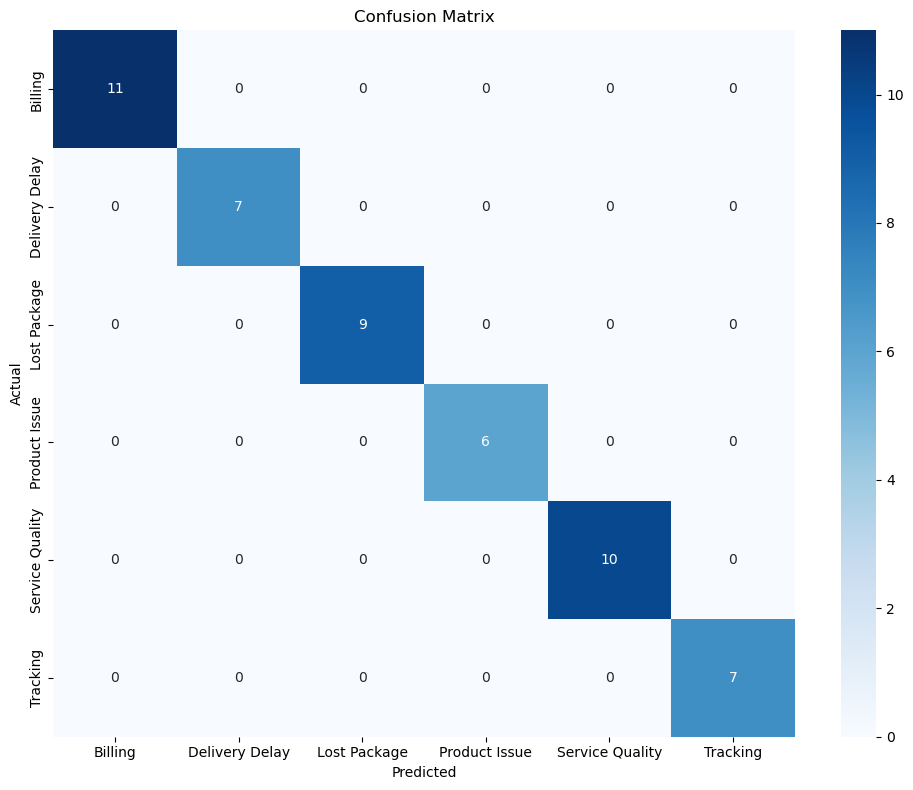

In [38]:
print("\n=== Model Evaluation ===")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(10, 8))
conf_mat = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# ========================
# 7. Prediction Function
# ========================

In [40]:
def classify_ticket(text):
    """Classify a new support ticket"""
    cleaned = preprocess_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    probabilities = model.predict_proba(vectorized)[0]
    
    return {
        "text": text,
        "category": prediction,
        "confidence": round(max(probabilities), 2),
        "probabilities": dict(zip(model.classes_, np.round(probabilities, 2)))
    }

# Test prediction
test_tickets = [
    "My package hasn't arrived even though it was supposed to come yesterday",
    "I was charged twice for my order T-456789",
    "The delivery guy threw my package on the porch",
    "How do I track my international shipment?",
    "Received a blue shirt when I ordered red"
]

print("\n=== Test Predictions ===")
for ticket in test_tickets:
    result = classify_ticket(ticket)
    print(f"\nText: {result['text']}")
    print(f"Predicted: {result['category']} (Confidence: {result['confidence']})")
    print("Probabilities:", result['probabilities'])


=== Test Predictions ===

Text: My package hasn't arrived even though it was supposed to come yesterday
Predicted: Delivery Delay (Confidence: 0.34)
Probabilities: {'Billing': 0.13, 'Delivery Delay': 0.34, 'Lost Package': 0.27, 'Product Issue': 0.09, 'Service Quality': 0.07, 'Tracking': 0.1}

Text: I was charged twice for my order T-456789
Predicted: Billing (Confidence: 0.47)
Probabilities: {'Billing': 0.47, 'Delivery Delay': 0.12, 'Lost Package': 0.12, 'Product Issue': 0.08, 'Service Quality': 0.09, 'Tracking': 0.12}

Text: The delivery guy threw my package on the porch
Predicted: Service Quality (Confidence: 0.43)
Probabilities: {'Billing': 0.09, 'Delivery Delay': 0.18, 'Lost Package': 0.18, 'Product Issue': 0.05, 'Service Quality': 0.43, 'Tracking': 0.07}

Text: How do I track my international shipment?
Predicted: Tracking (Confidence: 0.92)
Probabilities: {'Billing': 0.02, 'Delivery Delay': 0.02, 'Lost Package': 0.02, 'Product Issue': 0.01, 'Service Quality': 0.01, 'Tracking': 0.

# ========================
# 8. Feature Importance
# ========================


=== Feature Importance ===

Top 20 Important Features:
                    feature  importance
45                  deliver    0.060635
98                  product    0.054856
48                 delivery    0.051732
110                 service    0.044492
115                shipment    0.037260
126                   track    0.033199
100                 receive    0.030608
41                    delay    0.028446
84                  package    0.024696
12                     2025    0.023560
18                   arrive    0.021592
91                      pay    0.021164
74                match pay    0.020145
141                   wrong    0.017972
26                   charge    0.016755
99           product arrive    0.015524
63                  invoice    0.015351
82                    order    0.014861
73                    match    0.014361
62   international shipment    0.013808


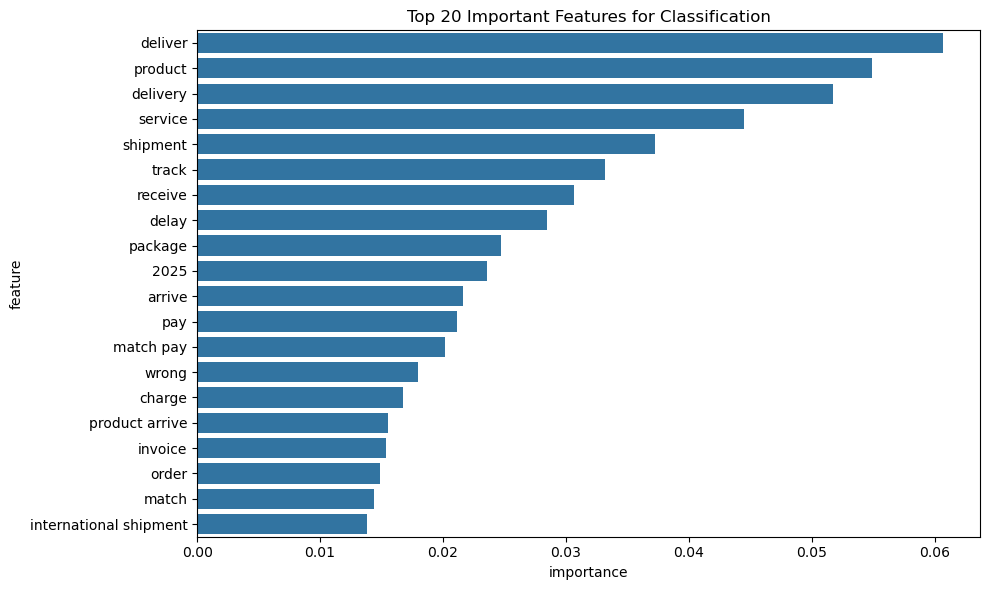

In [42]:
print("\n=== Feature Importance ===")
feature_names = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_features = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)

print("\nTop 20 Important Features:")
print(top_features)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x="importance", y="feature")
plt.title("Top 20 Important Features for Classification")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


# ========================
# 9. Business Insights
# ========================

In [44]:
print("\n=== Business Insights ===")
# Most common issues by urgency
print("\nMost Common Issues by Urgency:")
print(pd.crosstab(df["category"], df["urgency"], normalize="index"))

# Average confidence by category
category_probs = []
for cat in model.classes_:
    mask = (y_test == cat)
    if sum(mask) > 0:
        avg_conf = np.mean(model.predict_proba(X_test[mask])[:, model.classes_ == cat])
        category_probs.append((cat, avg_conf))

print("\nAverage Confidence by Category:")
for cat, prob in sorted(category_probs, key=lambda x: x[1], reverse=True):
    print(f"{cat}: {prob:.2f}")


=== Business Insights ===

Most Common Issues by Urgency:
urgency              High       Low    Medium
category                                     
Billing          0.461538  0.410256  0.128205
Delivery Delay   0.302326  0.348837  0.348837
Lost Package     0.348837  0.279070  0.372093
Product Issue    0.432432  0.324324  0.243243
Service Quality  0.346939  0.244898  0.408163
Tracking         0.205128  0.384615  0.410256

Average Confidence by Category:
Tracking: 0.81
Product Issue: 0.68
Service Quality: 0.65
Billing: 0.62
Lost Package: 0.60
Delivery Delay: 0.57


# ========================
# 10. Save Model
# ========================

In [46]:
import joblib
print("\nSaving model pipeline...")
pipeline = make_pipeline(vectorizer, model)
joblib.dump(pipeline, "ticket_classifier_pipeline.joblib")

print("\n=== Project Complete ===")


Saving model pipeline...

=== Project Complete ===
